In [1]:

# === 1. 加载数据 ===

import chardet
import os
import pandas as pd
from typing import Union
from io import BytesIO

def sanitize_file_name(filepath: str) -> str:
    return os.path.splitext(os.path.basename(filepath))[0].replace(".", "_").replace(" ", "_")

def get_table_name_from_path(filepath: Union[str, BytesIO]) -> str:
    return (
        f"table_{sanitize_file_name(filepath)}"
        if isinstance(filepath, str)
        else "table_from_bytes"
    )

def read_csv(filepath: Union[str, BytesIO]) -> pd.DataFrame:
    data = pd.read_csv(filepath, encoding='GBK')
    table_name = get_table_name_from_path(filepath)
    return data, table_name

def read_excel(filepath: Union[str, BytesIO], sheet_name: Union[str, int, None] = 0) -> pd.DataFrame:
    data = pd.read_excel(filepath, sheet_name=sheet_name)
    table_name = get_table_name_from_path(filepath)
    return data, table_name

data, table_name = read_csv(r"C:\Users\传防科电脑\Desktop\2025.1.1-2025.7.3.csv")
df = data
data.head(5)

,卡片ID,卡片编号,卡片状态,患者姓名,患儿家长姓名,有效证件号,性别,出生日期,年龄,患者工作单位,...,订正终审时间,终审死亡时间,订正用户,订正用户所属单位,（删除/标注）时间,（删除/标注）用户,（删除/标注）用户所属单位,（删除/未纳入统计）原因,备注,Unnamed: 46
0,'1390349908675436544,611002051-2025-00368,原始卡,寇秀梅,NaN,'612501195103082240',女,1951-03-08,74岁,NaN,...,2025-07-03 15:22:00,.,NaN,NaN,.,NaN,NaN,NaN,NaN,NaN
1,'1390275815731286016,611002046-2025-00448,原始卡,南忠良,NaN,'612501196005055411',男,1960-05-05,65岁,NaN,...,2025-07-03 10:32:42,.,NaN,NaN,.,NaN,NaN,NaN,NaN,NaN
2,'1390253312063348736,611002050-2025-00007,原始卡,姜添添,NaN,'61100220051030122X',女,2005-10-30,19岁,无,...,2025-07-03 09:01:28,.,NaN,NaN,.,NaN,NaN,NaN,快速血浆反应 阳性 血液凝集法 滴度 1:16,NaN
3,'1390248929133424640,611002054-2025-00003,原始卡,唐欠欠,NaN,'612501199407207880',女,1994-07-20,30岁,商州区夜村镇白杨店村7组,...,2025-07-03 08:34:24,.,NaN,NaN,.,NaN,NaN,NaN,NaN,NaN
4,'1390026244969295872,611002045-2025-01560,原始卡,武传岐,NaN,'61252519410922121X',男,1941-09-22,83岁,NaN,...,2025-07-02 17:52:23,.,NaN,NaN,.,NaN,NaN,NaN,A16.900x002，结核感染，A16.900x002，结核感染，A16.900x002，...,NaN


In [2]:

# === 2. 构造数据结构说明 ===

import pandas as pd
import json
from typing import List, Optional, Any

MAX_COLUMN_TEXT_LENGTH = 200

def get_column_type(column_dtype) -> Optional[str]:
    if pd.api.types.is_string_dtype(column_dtype):
        return "string"
    elif pd.api.types.is_integer_dtype(column_dtype):
        return "integer"
    elif pd.api.types.is_float_dtype(column_dtype):
        return "float"
    elif pd.api.types.is_datetime64_any_dtype(column_dtype):
        return "datetime"
    elif pd.api.types.is_bool_dtype(column_dtype):
        return "boolean"
    else:
        return None

def get_default_schema(dataframe: pd.DataFrame, table_name: Optional[str] = None) -> dict:
    columns_list = [
        {"name": str(name), "type": get_column_type(dtype)}
        for name, dtype in dataframe.dtypes.items()
    ]
    return {
        "name": table_name or "unknown_table",
        "source": {
            "type": "csv",   # 可替换为 parquet / excel
            "path": "data.csv",
        },
        "columns": columns_list,
    }

def truncate_value(value: Any) -> str:
    """Truncate long values and serialize JSON-like values."""
    if isinstance(value, (dict, list)):
        value = json.dumps(value, ensure_ascii=False)
    if isinstance(value, str) and len(value) > MAX_COLUMN_TEXT_LENGTH:
        return value[:MAX_COLUMN_TEXT_LENGTH] + "…"
    return value

def serialize_dataframe_to_prompt(df: pd.DataFrame, schema: dict, dialect: str = "csv", max_rows: int = 5) -> str:
    """Generate structured prompt string from df + schema."""
    
    result = f'<table dialect="{dialect}" table_name="{schema["name"]}"'

    if schema.get("columns"):
        columns_json = json.dumps(schema["columns"], ensure_ascii=False)
        result += f' columns="{columns_json}"'
    
    result += f' dimensions="{df.shape[0]}x{df.shape[1]}">\n'

    truncated_df = df.head(max_rows).apply(lambda col: col.map(truncate_value))
    csv_str = truncated_df.to_csv(index=False)
    result += csv_str

    result += "</table>\n"
    return result


schema = get_default_schema(data, table_name)
datasets = serialize_dataframe_to_prompt(data, schema)
datasets

'<table dialect="csv" table_name="table_2025_1_1-2025_7_3" columns="[{"name": "卡片ID", "type": "string"}, {"name": "卡片编号", "type": "string"}, {"name": "卡片状态", "type": "string"}, {"name": "患者姓名", "type": "string"}, {"name": "患儿家长姓名", "type": "string"}, {"name": "有效证件号", "type": "string"}, {"name": "性别", "type": "string"}, {"name": "出生日期", "type": "string"}, {"name": "年龄", "type": "string"}, {"name": "患者工作单位", "type": "string"}, {"name": "联系电话", "type": "string"}, {"name": "病人属于", "type": "string"}, {"name": "现住地址国标", "type": "integer"}, {"name": "现住详细地址", "type": "string"}, {"name": "人群分类", "type": "string"}, {"name": "病例分类", "type": "string"}, {"name": "病例分类2", "type": "string"}, {"name": "发病日期", "type": "string"}, {"name": "诊断时间", "type": "string"}, {"name": "死亡日期", "type": "string"}, {"name": "疾病名称", "type": "string"}, {"name": "订正前病种", "type": "string"}, {"name": "订正前诊断时间", "type": "string"}, {"name": "订正前终审时间", "type": "string"}, {"name": "填卡医生", "type": "string"}, {"name": "医生填卡日期"

In [3]:

# === 3. 构造 prompt ===

from typing import Optional

def build_type_hint(output_type: Optional[str] = None) -> str:
    if not output_type:
        return (
            'You must return a Python dictionary in the format: '
            '{"type": ..., "value": ...}.\n\n'
            'Allowed "type" values are: "string", "number", "dataframe", "plot".\n'
            'Examples:\n'
            '- { "type": "string", "value": "The highest salary is 100k." }\n'
            '- { "type": "number", "value": 125 }\n'
            '- { "type": "dataframe", "value": pd.DataFrame({...}) }\n'
            '- { "type": "plot", "value": "temp_chart.png" }\n\n'
            'The value must match the type. Do not include any extra explanation.'
        )

    examples = {
        "number": (
            'Output format: { "type": "number", "value": <int or float> }.\n'
            'Only return the number directly, no explanation.'
        ),
        "dataframe": (
            'Output format: { "type": "dataframe", "value": pd.DataFrame({...}) }.\n'
            'Only include the resulting DataFrame. Use pandas to process data.'
        ),
        "plot": (
            'Output format: { "type": "plot", "value": "<filename>.png" }.\n'
            'Save the plot to file and return the filename.'
        ),
        "string": (
            'Output format: { "type": "string", "value": "your summary here." }.\n'
            'Summarize the result in plain and understandable Chinese.'
        )
    }
    return examples.get(output_type, examples["string"])

system_prompt = (
    "你是一名经验丰富的数据分析师，擅长使用 Pandas 和 SQL 分析结构化数据，"
    "请根据提供的表格和用户问题生成完整的 Python 数据分析代码，"
    "并返回一个变量 `result = {\"type\": ..., \"value\": ...}`，用于封装输出类型和值。"
    "请严格按照指定格式返回代码，不要添加解释或额外输出。"
)


output_type = "plot"
type_hint = build_type_hint(output_type)

user_prompt = f"""
You are a professional data analyst. Your task is to generate Python code to answer the user's question using the provided datasets.

Note: The dataset shown above has already been loaded into a pandas DataFrame called `df`.
You should use this DataFrame directly in your code. Do not reload or redefine the data.
---

**User Input**: 帮我绘制2025年6月份流行性感冒病例的流行曲线。  
**Expected Output Type**: {output_type}

---

<tables>
{datasets}
</tables>

---

Please complete the following initial code:

```python
# TODO: import the required dependencies
import pandas as pd

# Write code here

# Declare result var: {build_type_hint(output_type)}
```
"""

system_prompt
user_prompt

'\nYou are a professional data analyst. Your task is to generate Python code to answer the user\'s question using the provided datasets.\n\nNote: The dataset shown above has already been loaded into a pandas DataFrame called `df`.\nYou should use this DataFrame directly in your code. Do not reload or redefine the data.\n---\n\n**User Input**: 帮我绘制2025年6月份流行性感冒病例的流行曲线。  \n**Expected Output Type**: plot\n\n---\n\n<tables>\n<table dialect="csv" table_name="table_2025_1_1-2025_7_3" columns="[{"name": "卡片ID", "type": "string"}, {"name": "卡片编号", "type": "string"}, {"name": "卡片状态", "type": "string"}, {"name": "患者姓名", "type": "string"}, {"name": "患儿家长姓名", "type": "string"}, {"name": "有效证件号", "type": "string"}, {"name": "性别", "type": "string"}, {"name": "出生日期", "type": "string"}, {"name": "年龄", "type": "string"}, {"name": "患者工作单位", "type": "string"}, {"name": "联系电话", "type": "string"}, {"name": "病人属于", "type": "string"}, {"name": "现住地址国标", "type": "integer"}, {"name": "现住详细地址", "type": "string"

In [4]:

# === 4. 调用 OpenAI 接口 ===

from openai import OpenAI

client = OpenAI()  # 使用默认环境变量 OPENAI_API_KEY

response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ],
    temperature=0.2,
)

generated_code = response.choices[0].message.content
print("🔧 模型生成的代码：\n", generated_code)


🔧 模型生成的代码：
 ```python
# TODO: import the required dependencies
import pandas as pd
import matplotlib.pyplot as plt

# Filter the data for June 2025 and for the disease "流行性感冒"
df['发病日期'] = pd.to_datetime(df['发病日期'], errors='coerce')
june_2025_flu_cases = df[(df['发病日期'].dt.year == 2025) & 
                         (df['发病日期'].dt.month == 6) & 
                         (df['疾病名称'] == '流行性感冒')]

# Group by the date of onset and count the number of cases each day
daily_cases = june_2025_flu_cases.groupby('发病日期').size()

# Plot the epidemic curve
plt.figure(figsize=(10, 6))
daily_cases.plot(kind='line', marker='o')
plt.title('Epidemic Curve of Influenza Cases in June 2025')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot to a file
filename = 'influenza_epidemic_curve_june_2025.png'
plt.savefig(filename)

# Declare result var: Output format: { "type": "plot", "value": "<filename>.png" }.
result = {"type": "plot", "va

{'type': 'plot', 'value': 'influenza_epidemic_curve_june_2025.png'}

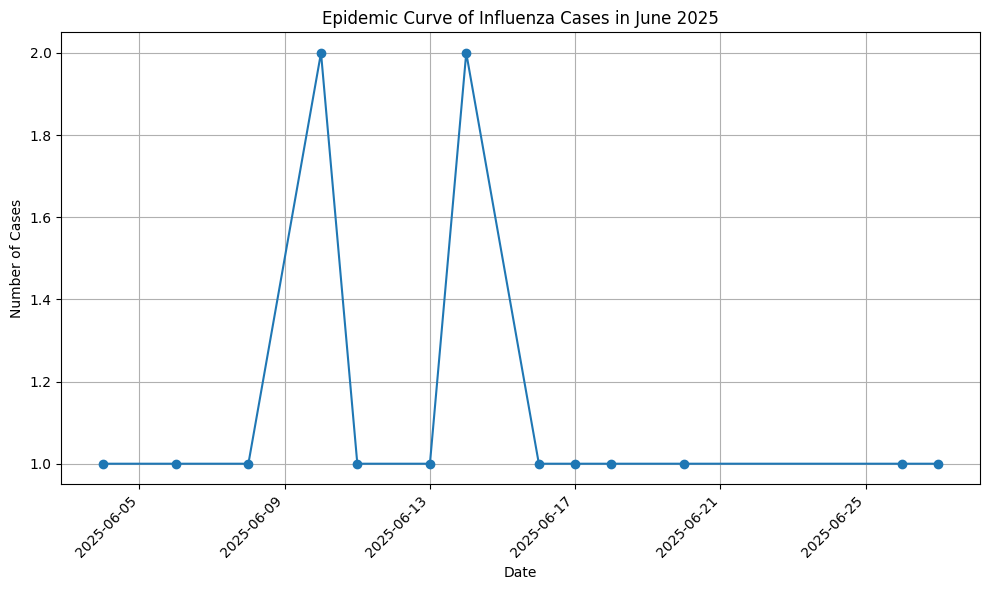

In [5]:

# === 5. 执行代码，注入 DataFrame df ===

import re

class CodeExecutionError(Exception): pass
class NoResultFoundError(Exception): pass
    
def clean_generated_code(code: str) -> str:

    code = code.strip()

    lines = code.splitlines()
    if lines and re.match(r"^```(\s*python)?", lines[0].strip(), re.IGNORECASE):
        lines = lines[1:]
    if lines and lines[-1].strip() == "```":
        lines = lines[:-1]

    return "\n".join(lines)

def execute(code: str):
    try:
        exec(code, globals())
    except Exception as e:
        raise CodeExecutionError("Code execution failed") from e

def execute_and_return_result(code: str):
    execute(code)
    if "result" not in globals():
        raise NoResultFoundError("No result returned")
    return globals()["result"]

In [ ]:

# === 6. 获取 result 变量 ===

df = df
globals()["df"] = df
generated_code = clean_generated_code(generated_code)
result = execute_and_return_result(generated_code)


In [ ]:

# === 7. 解析结果（ResponseParser）===
# 你提供的 ResponseParser 以及响应类型

class BaseResponse: pass
class NumberResponse(BaseResponse): 
    def __init__(self, value, code): self.value = value
class StringResponse(BaseResponse): 
    def __init__(self, value, code): self.value = value
class DataFrameResponse(BaseResponse): 
    def __init__(self, value, code): self.value = pd.DataFrame(value)
class ChartResponse(BaseResponse): 
    def __init__(self, value, code): self.value = value  # stub
class InvalidOutputValueMismatch(Exception): pass

class ResponseParser:
    def parse(self, result: dict, last_code_executed: str = None) -> BaseResponse:
        self._validate_response(result)
        return self._generate_response(result, last_code_executed)
    def _validate_response(self, result: dict):
        if not isinstance(result, dict) or "type" not in result or "value" not in result:
            raise ValueError("Invalid response format")
    def _generate_response(self, result: dict, last_code_executed: str = None):
        if result["type"] == "number":
            return NumberResponse(result["value"], last_code_executed)
        elif result["type"] == "string":
            return StringResponse(result["value"], last_code_executed)
        elif result["type"] == "dataframe":
            return DataFrameResponse(result["value"], last_code_executed)
        elif result["type"] == "plot":
            return ChartResponse(result["value"], last_code_executed)
        else:
            raise InvalidOutputValueMismatch(f"Invalid output type: {result['type']}")



In [ ]:
# === 8. 输出结果 ===
parsed = ResponseParser().parse(result, generated_code)
print("🎯 输出值:")
print(parsed.value)
